In [1]:
import pyemd
from choquet_integral import *
import random
import numpy as np
import xai_indices as xai
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.spatial import distance
from mpl_toolkits import mplot3d
from PIL import ImageDraw, Image, ImageColor, ImageFont
import itertools
import cv2
import time
import copy
import pandas
import pyemd

In [2]:
def random_node_fm(n):
    ch = ChoquetIntegral()
    ch.type='quad'
    ch.fm = {}
    ch.fm[str(np.arange(1,n+1))] = 1
    ch.fm['[]'] = 0
    ch.N = n
    ch.M = n
    numkeys = len(ch.get_keys_index())
    keys = list(ch.get_keys_index().keys())
    keys.append('[]')
    s = [0] * (numkeys + 1)
    s[-1] = 1
    s[-2] = 1
    done = False
    while not done:
        randindex = random.randrange(0,numkeys)
        if s[randindex] == 0:
            s[randindex] = 1
            if keys[randindex] != '[]':
                compare_key = [int(s) for s in keys[randindex][1:-1].split() if s.isdigit()]

            else:
                compare_key = []

            maxi = 0
            max_index = 0
            mini = 1
            min_index = 0
            for i,key in enumerate(keys):
                if s[i] == 1 and i != randindex:
                    if key != '[]':
                        stripped = [int(s) for s in key[1:-1].split() if s.isdigit()]
                    else:
                        stripped = []

                    if is_subset(stripped,compare_key) and s[i] == 1 and ch.fm[key] >= maxi:
                        maxi = ch.fm[key]
                        max_index = i
                    if is_subset(compare_key,stripped) and s[i] == 1 and ch.fm[key] <= mini:

                        mini = ch.fm[key]
                        min_index = i


            rb = ch.fm[keys[max_index]]
            ru = ch.fm[keys[min_index]]
            g = random.uniform(rb,ru)
            ch.fm[keys[randindex]] = g

        else:
            pass
        if min(s) == 1:
            done = True
    return ch

def is_subset(a,b):
    if len(a) == 0:
        return True
    if len(b) == 0 and len(a) != 0:
        return False
    for val in a:
        if val not in b:
            return False
    else:
        return True
    
def gen_unit_distance_matrix(n):
    distance_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i][j] = np.abs(i-j)
    return distance_matrix 

def gen_datapoints(m,n):
    points = []
    for i in range(n):
        point = []
        for j in range(m):
            point.append(random.random())
        points.append(point)
    return np.asarray(points)

def sample_with_noise(ch,data,mean,var):
    labels = np.zeros(data.shape[0])
    for i,point in enumerate(data):
        labels[i] = max(min(ch.chi_quad(point) + random.gauss(mean,var),1),0)
    return labels

def percentage_walks_observed(walks):
    seen = 0
    total = 0
    for key in walks.keys():
        if walks[key] > 0:
            seen = seen + 1
        total = total+1
    return seen/total

In [4]:
def fm_emd_diff(ch1,ch2):
    fm1 = ch1.generate_walk_diffs()
    fm2 = ch2.generate_walk_diffs()

    total_diff = 0
    dist_mat = gen_unit_distance_matrix(5)
    for i in range(len(fm1)):
        total_diff += pyemd.emd(fm1[i],fm2[i],dist_mat)

    total_diff /= len(walk_diffs1)
    return total_diff

def data_emd_diff(ch1,ch2,walks1,walks2):

    max_diff = 0
    min_diff = 100000
    
    fm1 = ch1.generate_walk_diffs()
    fm2 = ch2.generate_walk_diffs()
    
    walk1_total = 0
    walk2_total = 0
    for i in range(len(list(walks1.values()))):
        if list(walks1.values())[i] > 0 and list(walks2.values())[i] > 0:
            walk1_total += list(walks1.values())[i]
            walk2_total += list(walks2.values())[i]
        else:
            # non-intersecting walk
            pass
        
    total_diff = 0
    dist_mat = gen_unit_distance_matrix(5)
    for i in range(len(fm1)):
 
        f1 = list(walks1.values())[i]/ walk1_total
        f2 = list(walks2.values())[i]/ walk2_total
        
        if f1 > 0 and f2 > 0:
            d = pyemd.emd(fm1[i],fm2[i],dist_mat)
            diff = d * (f1 + f2)
            if d > max_diff:
                max_diff = d
                maxdex = i
            if d < min_diff:
                min_diff = d
                mindex = i
            total_diff += diff
        
    total_diff /= 2
    return (total_diff,(min_diff,list(walks1.keys())[mindex]),(max_diff,list(walks1.keys())[maxdex]))

In [5]:
avg_dists = []
avg_weighted_dists = []
max_dists = []
min_dists = []

for i in range(3):
    fm1 = random_node_fm(5)
    fm2 = random_node_fm(5)
    walk_diffs1 = fm1.generate_walk_diffs()
    walk_diffs2 = fm2.generate_walk_diffs()
    data = gen_datapoints(5,300)
    data2 = gen_datapoints(5,300)
    noisy_labels = sample_with_noise(fm1,data,0,0)
    noisy_labels2 = sample_with_noise(fm2,data,0,0)

    ch1 = ChoquetIntegral()
    ch1.train_chi(data.T,noisy_labels)

    ch2 = ChoquetIntegral()
    ch2.train_chi(data.T,noisy_labels2)

    (walks1,_) = xai.walk_visitation(data.T)
    (walks2,_) = xai.walk_visitation(data.T)
    # print(walks)
    # print(percentage_walks_observed(walks))
    # print(percentage_walks_observed(walks2))
    diff = fm_emd_diff(ch1,ch2)
    (weighted_diff,(min_diff,_),(max_diff,_)) = data_emd_diff(ch1,ch2,walks1,walks2)
    
    avg_dists.append(diff)
    avg_weighted_dists.append(weighted_diff)
    max_dists.append(max_diff)
    min_dists.append(min_diff)

#     print("reg",diff)
#     print("weighted",weighted_diff)
#     print("Min distance:", min_diff)
#     print("Max distance:", max_diff)


In [5]:
viridis = cm.get_cmap('plasma')

# gen_unit_distance_matrix(2)

In [7]:
a = [0.3,0.5,.2]
hue = 360 / len(a)

img = Image.new('RGB', (640,640), (255,255,255))
draw = ImageDraw.Draw(img)
old_angle = 0
if np.sum(a) != 1:
    pass

else:
    for i in range(len(a)):
        h = hue * i
        start_angle = old_angle
        end_angle = old_angle + (360 * a[i])
        old_angle = end_angle
        draw.pieslice([(0,0),(640,640)], start_angle, end_angle, fill="hsv("+str(int(h))+",100%,100%)")
        

img.show()

In [8]:
def draw_color_hasse(size):
    w,h = 640,640
    img = Image.new('RGB', (w,h), (255,255,255))
    draw = ImageDraw.Draw(img)
    
    points = {}
    for i in range(size+1):
        vert_off = h / (size+1)
        
        combs = list(itertools.combinations(np.arange(1,size+1),i))
        num_nodes = len(combs)
        horz_off = w / num_nodes
        
        for j in range(num_nodes):
            key = list(combs)[j]
            points[key] = (int(horz_off * (j + .5)), int(h - vert_off*(i+.5)))
            
    
    for i in range(size,0,-1):
        parent_keys = list(itertools.combinations(np.arange(1,size+1),i))
        
        for pkey in parent_keys:
            for j in range(len(pkey)):
                ckey = pkey[0:j] + pkey[j+1:len(pkey)]
                draw.line([points[pkey],points[ckey]],width=3,fill=(0,0,0))
        


#     for key in points.keys():
#         draw.point(points[key],fill=(0,0,0))
    
#     img.show()
    return(points,img)
    
    

In [ ]:
draw_color_hasse(5)

In [10]:
a = (1,0,2)
i = 1
b1 = a[0:i]
b2 = a[i+1:len(a)]
print(b1 + b2)

(1, 2)


In [9]:
def all_lcs(d,inc):
    return_list = []
    expand_list = []
    started = False
    
    while len(expand_list) > 0 or not started:
        if started == False:
            current_lcs = []
            started = True
        else:
            current_lcs = expand_list.pop(0)
            
        if sum(current_lcs) >= 1:
            while(len(current_lcs) < d):
                current_lcs.append(0)
            return_list.append(current_lcs)
        else:
            expand_list.extend(recurse_lcs(d,inc,current_lcs))
            

    return return_list
        
        
        
def recurse_lcs(d,inc,current_lcs):
    return_list = []
    if np.sum(current_lcs) >= 1:
        while(len(current_lcs) < d):
            current_lcs.append(0)
        
        return current_lcs
    
    if len(current_lcs) < d - 1:
        for i in range(int(1.0/inc) + 1):
            if np.sum(current_lcs) + (i*inc) <= 1:
                new_lcs = current_lcs.copy()
                new_lcs.append(i*inc)
                return_list.append(new_lcs)
    
    elif len(current_lcs) == d - 1:
        new_lcs = current_lcs.copy()
        new_lcs.append(1 - np.sum(new_lcs))
        return_list.append(new_lcs)
        
    return return_list


lcs_list = all_lcs(3,.03)

# recurse_lcs(3,.1,[])

In [11]:
viridis(.5)

NameError: name 'viridis' is not defined

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('w3')
f = plt.gcf()
f.set_size_inches(3,3)
ax.view_init(45,45)
ax.set_title("Distance from Max using EMD")

for lcs in lcs_list:
    [x,y,z] = lcs
    dist = pyemd.emd(np.asarray(lcs),np.asarray([1,0,0],dtype=float),gen_unit_distance_matrix(3)) / 2
    (r,g,b,a) = viridis(dist)
    ax.scatter(x,y,z, c=np.asarray([r,g,b]).reshape(1,-1))
    

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('w3')
f = plt.gcf()
f.set_size_inches(3,3)
ax.set_title("Distance from Max using L2")
ax.view_init(45,45)
for lcs in lcs_list:
    [x,y,z] = lcs
    dist = distance.euclidean(lcs,np.asarray([1,0,0])) / np.sqrt(2)
    (r,g,b,a) = viridis(dist)
    ax.scatter(x,y,z, c=np.asarray([r,g,b]).reshape(1,-1))

In [16]:

def pairwise_dissimilarity(X,euclidean=False):
    pairwise = np.zeros((X.shape[0],X.shape[0]))
    distance_matrix = gen_unit_distance_matrix(X.shape[1])
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if i == j:
                pairwise[i][j] = 0
            else:
                if euclidean:
                    diff = distance.euclidean(X[i],X[j])
                else:
                    diff = pyemd.emd(X[i],X[j],distance_matrix)
#                 diff = distance.euclidean(X[i],X[j])
                pairwise[i][j]=diff
    return pairwise

def undo_vat_order(vat,indices):
    return_mat = np.zeros_like(vat)
    
    for i in range(vat.shape[0]):
        for j in range(vat.shape[1]):
            (x,y) = indices[i][j]
            return_mat[x,y] = vat[i,j]
    return return_mat

def vat(dm):
    vat_res = np.zeros_like(dm)
    indices = np.zeros(vat_res.shape, dtype=(int,2))
    K = set(np.arange(0,dm.shape[0],1))
    P = np.zeros(dm.shape[0],dtype=int)
    I = set()
    J = set()

    (i,j) = np.unravel_index(dm.argmax(), dm.shape)
    
    P[0] = i
    I.add(i)
    J = K - I

    for r in range(1,dm.shape[0]):
        temp_matrix = np.zeros((len(I),len(J)))
        matrix_indices = np.zeros(temp_matrix.shape,dtype=(int,2))
        
        for s in range(len(I)):
            for t in range(len(J)):
                temp_matrix[s,t] = dm[list(I)[s],list(J)[t]]
                matrix_indices[s,t] = (list(I)[s], list(J)[t])
                

        (i,j) = np.unravel_index(temp_matrix.argmin(), temp_matrix.shape)
        (i,j) = matrix_indices[i,j]
        
        P[r] = j
        I.add(j)
        J = J - {j}
        
    for i in range(len(dm)):
        for j in range(len(dm)):
            vat_res[i,j] = dm[P[i],P[j]]
            indices[i,j] = (P[i],P[j])
                              
        
    return (vat_res, indices)

def ivat(odm):
    Dp = np.zeros_like(odm)
    for r in range(1,odm.shape[0]):
        j = np.argmin(odm[r,0:r])
        Dp[r][j] = odm[r][j]
        for m in range(0,r):
            if m != j:
                Dp[r][m] = max(odm[r][j],Dp[j][m])         
                
    for i in range(len(odm)):
        for j in range(len(odm)):
            if j >= i:
                Dp[i][j] = Dp[j][i]
    return Dp
    

In [ ]:
# a = [1,1,1,1,3,3,3,3,10,10,10,10,10,10]
ch = random_node_fm(5)
walk_diffs = np.asarray(ch.generate_walk_diffs())

walk_diff_matrix = pairwise_dissimilarity(walk_diffs)

(img,indices) = vat(walk_diff_matrix)

plt.figure()
plt.imshow(img,cmap="gray")
# b = pairwise_dissimilarity(np.asarray(a))

# (img,indices) = vat(b)
# img = img / np.max(img)
# plt.imshow(img,cmap="gray")

In [ ]:
%matplotlib notebook
ivat_img = ivat(img)
# plt.imshow(img,cmap="gray")
# img = img / np.max(img)
plt.imshow(ivat_img, cmap="gray")

In [19]:
def select_vat_region(indices,start,stop):
    if stop < start:
        print("dummy")
    
    crop = indices[start][start:stop+1]
    crop = np.ndarray.flatten(crop)
    crop = np.unique(crop)
    return crop

def draw_pie(xy,percents,img,colors):
    size = 25
    draw = ImageDraw.Draw(img)
    percents = percents / np.sum(percents)
    
    start_angles = [359] * len(percents)
    for i in range(len(percents)):
        start_angles[i] = np.sum(percents[0:i]) * 360
        
#     print(start_angles)
#     print(end_angles)
        
#     x1,y1 = int(xy[0] - size), int(xy[1] - size)
#     x2,y2 = int(xy[0] + size), int(xy[1] + size)
#     draw.pieslice([x1,y1,x2,y2],0,359,fill="hsv("+str(colors[i])+",80%,100%)")

    for i,angle in enumerate(start_angles):
        x1,y1 = int(xy[0] - size), int(xy[1] - size)
        x2,y2 = int(xy[0] + size), int(xy[1] + size)
        if percents[i] > 0:
#         if ((i + 1) % len(angles)) == 0:
#             if len(angles) == 1:
#                 draw.pieslice([x1,y1,x2,y2],angles[i],359,fill="hsv("+str(colors[i])+",80%,100%)")
#             draw.pieslice([x1,y1,x2,y2],angles[i],359,fill="hsv("+str(colors[i])+",80%,100%)")
#         else:
            draw.pieslice([x1,y1,x2,y2],start_angles[i]-90,359-90,fill="hsv("+str(colors[i])+",80%,100%)")
        
    return img
        
    
    
    

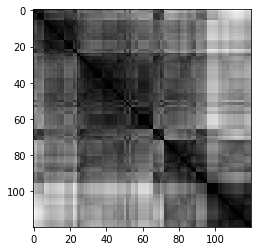

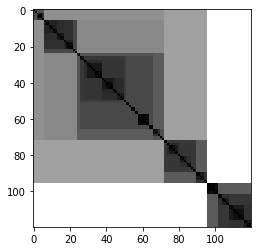

In [17]:
ch = random_node_fm(5)
walk_diffs = ch.generate_walk_diffs()
walk_matrix = pairwise_dissimilarity(walk_diffs)
(vat_img,indices) = vat(walk_matrix)
plt.figure()
plt.imshow(vat_img,cmap="gray")
plt.figure()
ivat_img = ivat(vat_img)
plt.imshow(ivat_img,cmap="gray")

In [20]:
crops = [[0,23],[23,48],[49,119]]
scopes = [select_vat_region(indices,x[0],x[1]) for x in crops]
walk_keys = list(itertools.permutations([1,2,3,4,5],5))
(points,img) = draw_color_hasse(5)
colors = [25,180,75,250]
color_master = {}

for key in points.keys():
    color_master[key] = [0] * len(scopes)
    
    
avg_loss = []
sigmas = []
for i,scope in enumerate(scopes):
    los = []
    for key in scope:
        los.append(walk_diffs[key])
        k = walk_keys[key]
        color_master[()][i] = color_master[()][i] + 1
        for j in range(0,len(k)):
            short = k[0:j+1]
            short = tuple(np.sort(list(short)))
            color_master[short][i] = color_master[short][i] + 1
    avg_loss.append(np.mean(los,axis=0))

    

for key in color_master.keys():
    img = draw_pie(points[key],color_master[key],img,colors)
    
draw = ImageDraw.Draw(img)

startx = 400
starty = 520
y_off = 20
font = ImageFont.load_default()

for i,los in enumerate(avg_loss):
    text = "("
    for j,val in enumerate(los):
        valstr = str(f"{val:.2f}")
        text = text + valstr + "x" + str(j) + "+"
    text = text + ")"
    draw.text([startx,starty+(y_off*i)],text,fill="hsv("+str(colors[i])+",80%,100%)")


img.show()
for los in avg_loss:
    print(los)
# print(color_master)
    

[0.10477841 0.52194049 0.07626845 0.19274978 0.10426287]
[0.08710125 0.18234382 0.46390799 0.19537722 0.07126973]
[0.12134618 0.13270553 0.23570757 0.24121105 0.26902967]


3
5
13
16
19
22
2
4
12
17
18
23
0
1
14
15
20
21
6
7
8
9
10
11
got here?
[0. 0. 0. 1.]
[0. 0. 1. 0.]
[0. 1. 0. 0.]
[1. 0. 0. 0.]


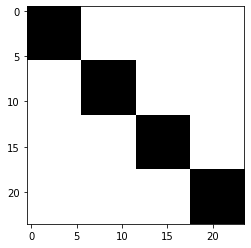

In [21]:
simple_ch = ChoquetIntegral()
split_fm = {}
split_fm['[]'] = 0
split_fm[str(np.asarray([1]))] = 0
split_fm[str(np.asarray([2]))] = 1
split_fm[str(np.asarray([3]))] = 0
split_fm[str(np.asarray([4]))] = 0
split_fm[str(np.asarray([1,2]))] = 1
split_fm[str(np.asarray([1,3]))] = 0
split_fm[str(np.asarray([1,4]))] = 0
split_fm[str(np.asarray([2,3]))] = 1
split_fm[str(np.asarray([2,4]))] = 1
split_fm[str(np.asarray([3,4]))] = 0
split_fm[str(np.asarray([1,2,3]))] = 1
split_fm[str(np.asarray([1,2,4]))] = 1
split_fm[str(np.asarray([1,3,4]))] = 0
split_fm[str(np.asarray([2,3,4]))] = 1
split_fm[str(np.asarray([1,2,3,4]))] = 1

# split_fm[str(np.asarray([5]))] = .2
# split_fm[str(np.asarray([1,5]))] = .4
# split_fm[str(np.asarray([2,5]))] = .4
# split_fm[str(np.asarray([3,5]))] = .4
# split_fm[str(np.asarray([4,5]))] = .4
# split_fm[str(np.asarray([1,2,5]))] = .6
# split_fm[str(np.asarray([1,3,5]))] = .6
# split_fm[str(np.asarray([1,4,5]))] = .6
# split_fm[str(np.asarray([2,3,5]))] = .6
# split_fm[str(np.asarray([2,4,5]))] = .6
# split_fm[str(np.asarray([3,4,5]))] = .6
# split_fm[str(np.asarray([1,2,3,5]))] = .6
# split_fm[str(np.asarray([1,2,4,5]))] = .6
# split_fm[str(np.asarray([1,3,4,5]))] = .9
# split_fm[str(np.asarray([2,3,4,5]))] = .9
# split_fm[str(np.asarray([1,2,3,4,5]))] = 1

simple_ch.fm = split_fm
simple_ch.N = 4
simple_ch.M = 4

walk_diffs = simple_ch.generate_walk_diffs()
diff_matrix = pairwise_dissimilarity(np.asarray(walk_diffs),euclidean=False)
(vat_img, reorder_indices) = vat(diff_matrix)

ivat_img = ivat(vat_img)

# plt.figure()
# plt.imshow(vat_img,cmap='gray')
plt.figure()
plt.imshow(ivat_img,cmap='gray')

make_color_hasse(simple_ch,ivat_img,reorder_indices,[[0,5],[6,11],[12,17],[18,23]])



In [15]:
def make_color_hasse(ch,ivat,indices,selections):
    scopes = [select_vat_region(indices,x[0],x[1]) for x in selections]
    walk_keys = list(itertools.permutations(np.arange(1,ch.M+1,1),ch.M))
    (points,img) = draw_color_hasse(ch.M)
    colors = [25,180,75,250,330]
    color_master = {}

    for key in points.keys():
        color_master[key] = [0] * len(scopes)


    avg_loss = []
    sigmas = []
    for i,scope in enumerate(scopes):
        los = []
        for key in scope:
            print(key)
            los.append(walk_diffs[key])
            k = walk_keys[key]
            color_master[()][i] = color_master[()][i] + 1
            for j in range(0,len(k)):
                short = k[0:j+1]
                short = tuple(np.sort(list(short)))
                color_master[short][i] = color_master[short][i] + 1
        avg_loss.append(np.mean(los,axis=0))


    print("got here?")
    for key in color_master.keys():
        img = draw_pie(points[key],color_master[key],img,colors)

    draw = ImageDraw.Draw(img)

    startx = 400
    starty = 520
    y_off = 20

#     for i,los in enumerate(avg_loss):
#         text = "("
#         for j,val in enumerate(los):
#             valstr = str(f"{val:.2f}")
#             text = text + valstr + "x" + str(j) + "+"
#         text = text + ")"
#         draw.text([startx,starty+(y_off*i)],text,fill="hsv("+str(colors[i])+",80%,100%)")


    img.show()
    for los in avg_loss:
        print(los)
    # print(color_master)
    


[20  8]
1.6408272816960003
0.99994900005


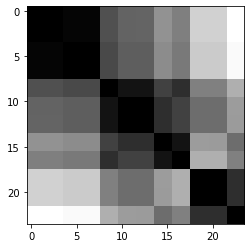

In [26]:
##### our integral
chi = ChoquetIntegral()

# load the training file 
# 02.txt: https://github.com/aminb99/remote-sensing-nn-datasets/blob/master/AID_4net_dataset/NNFold_1/Fold_1/test/02.txt
# _02.txt: https://github.com/aminb99/remote-sensing-nn-datasets/blob/master/AID_dataset/NNFold_1/Fold_1/test/02.txt
df = pandas.read_csv('20.txt')
df

# how many nets? 
n = 4 # 7
# suck out labels and data
training_labels = np.asarray( df.values )[:,n]
training_data = np.asarray( df.values )[:,0:n]
# for class ?, make this a binary learning problem
locs = np.where(training_labels == 19)
# print(locs)
labels = np.zeros(training_labels.shape)
labels[locs] = 1
# train the integral
chi.train_chi(training_data.transpose(), labels)
chi.M = 4
chi.N = 4
chi.fm['[]'] = 0
# print(chi.fm)

diss1 = pairwise_dissimilarity(np.asarray(chi.generate_walk_diffs()),euclidean=False)

(vat_img1,indices1) = vat(diss1)

ivat_img1 = ivat(vat_img1)

max_diss = np.max(vat_img1)

print(indices1[8,10])
i_s = indices1[14,18]

d1 = chi.generate_walk_diffs()[i_s[0]]
d2 = chi.generate_walk_diffs()[i_s[1]]
print(np.max(vat_img1))
print(pyemd.emd(d1,d2,gen_unit_distance_matrix(4)))
plt.figure()
plt.imshow(vat_img1,cmap='gray')


# print(np.mean(diss1),np.std(diss1))

In [38]:
print(training_data.T.shape)
print(xai.walk_visitation(training_data.T))

(4, 999)
({(1, 2, 3, 4): 957, (1, 2, 4, 3): 0, (1, 3, 2, 4): 1, (1, 3, 4, 2): 4, (1, 4, 2, 3): 2, (1, 4, 3, 2): 3, (2, 1, 3, 4): 2, (2, 1, 4, 3): 2, (2, 3, 1, 4): 3, (2, 3, 4, 1): 13, (2, 4, 1, 3): 0, (2, 4, 3, 1): 1, (3, 1, 2, 4): 3, (3, 1, 4, 2): 0, (3, 2, 1, 4): 1, (3, 2, 4, 1): 1, (3, 4, 1, 2): 2, (3, 4, 2, 1): 2, (4, 1, 2, 3): 0, (4, 1, 3, 2): 0, (4, 2, 1, 3): 1, (4, 2, 3, 1): 1, (4, 3, 1, 2): 0, (4, 3, 2, 1): 0}, {(1, 2, 3, 4): 0.9579579579579579, (1, 2, 4, 3): 0.0, (1, 3, 2, 4): 0.001001001001001001, (1, 3, 4, 2): 0.004004004004004004, (1, 4, 2, 3): 0.002002002002002002, (1, 4, 3, 2): 0.003003003003003003, (2, 1, 3, 4): 0.002002002002002002, (2, 1, 4, 3): 0.002002002002002002, (2, 3, 1, 4): 0.003003003003003003, (2, 3, 4, 1): 0.013013013013013013, (2, 4, 1, 3): 0.0, (2, 4, 3, 1): 0.001001001001001001, (3, 1, 2, 4): 0.003003003003003003, (3, 1, 4, 2): 0.0, (3, 2, 1, 4): 0.001001001001001001, (3, 2, 4, 1): 0.001001001001001001, (3, 4, 1, 2): 0.002002002002002002, (3, 4, 2, 1): 0.0

In [37]:
make_color_hasse(chi,ivat_img1,indices1,[[0,7],[8,13],[14,17],[18,23]])

0
1
4
5
6
7
18
19
2
3
8
10
20
22
9
11
21
23
12
13
14
15
16
17
got here?
[0.01165102 0.12412112 0.76466183 0.05535704 0.04420899]
[0.01165102 0.10882502 0.39222564 0.44157838 0.04571995]
[0.01165102 0.07823282 0.33460804 0.45618906 0.11931906]
[0.01165102 0.37951275 0.32683497 0.20973367 0.07226759]
